In [1]:
import os
import sys

local_path = os.getcwd()
# 设置工作目录为项目的主目录
os.chdir(os.path.join(local_path, "../../"))  # 使用相对路径将工作目录切换到 project 文件夹
print("Current working directory:", os.getcwd())
project_path = os.path.abspath(os.path.join(local_path, "../../"))
sys.path.append(project_path)   #将模块查找路径切换

Current working directory: /home/yixiong_ren/work/FBM


In [2]:
import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from utils import *
set_seed(42)  # 42 是一个示例种子数，您可以根据需求更改

Using device: cuda


# 加载数据集

In [29]:
selected_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cselected_classeslass_counts = [100]*len(selected_classes)
datatype = 'CIFAR10'
images_size = 3*32*32

train_loader = get_dataloader(datatype, batch_size=64, train=True, selected_classes=selected_classes, class_counts=cselected_classeslass_counts)
test_loader = get_dataloader(datatype, batch_size=64, train=False, selected_classes=selected_classes, class_counts=cselected_classeslass_counts)

#train_loader, test_loader = load_small_cifar10(loaad_size=100)

train_features = []
train_labels = []

for batch_data, batch_labels in train_loader:
    train_features.append(batch_data.view(-1, images_size))
    train_labels.append(batch_labels)

# 合并所有批次
train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

# 获取 DataLoader 中的全部数据
test_features = []
test_labels = []

for batch_data, batch_labels in test_loader:
    test_features.append(batch_data.view(-1, images_size))
    test_labels.append(batch_labels)

# 合并所有批次
test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
origin_train_features = []

for batch_data, batch_labels in train_loader:
    origin_train_features.append(batch_data)

# 合并所有批次
origin_train_features = torch.cat(origin_train_features, dim=0)

# 获取 DataLoader 中的全部数据
origin_test_features = []

for batch_data, batch_labels in test_loader:
    origin_test_features.append(batch_data)

# 合并所有批次
origin_test_features = torch.cat(origin_test_features, dim=0)

# 原始数据的聚类正确率

In [31]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np

data = test_features.numpy()  # 展平
labels = test_labels.numpy()
print(labels.shape)

# 2. 应用KMeans聚类
n_clusters = len(selected_classes)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(data)

# 3. 创建混淆矩阵
confusion_matrix = np.zeros((n_clusters, 10), dtype=np.int32)
for cluster in range(n_clusters):
    cluster_labels = labels[cluster_assignments == cluster]
    for label in range(10):
        confusion_matrix[cluster, label] = np.sum(cluster_labels == label)

print("混淆矩阵：")
print(confusion_matrix)

# 4. 使用匈牙利算法找到最佳标签分配
# 我们需要最大化正确分类，因此将混淆矩阵取负作为成本矩阵
cost_matrix = -confusion_matrix
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# 创建标签映射
cluster_to_label = {}
for cluster, label in zip(row_ind, col_ind):
    cluster_to_label[cluster] = label

print("\n聚类到标签的映射：")
for cluster in cluster_to_label:
    print(f"聚类 {cluster} -> 标签 {cluster_to_label[cluster]}")

# 5. 使用映射分配标签并计算准确率
predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_assignments])
accuracy = accuracy_score(labels, predicted_labels)
print(f"\n分类准确率: {accuracy * 100:.2f}%")

(5000,)


/home/yixiong_ren/anaconda3/envs/normal/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


混淆矩阵：
[[ 79  21  76  63  49  79  26  47  33   6]
 [ 27  62 131  86 135  87 129  84  14  51]
 [ 64  43  24  16   8  15   5  29 162  84]
 [118  33  43  38  10  22  23  23  21  32]
 [ 24  78  77  75  97  48 139  34  12  31]
 [ 36  47  41  55  40  56  56  82  12  60]
 [ 12  26  35  66  97  67  41  72  16  22]
 [ 34  65  17  27  20  23  13  72  71 158]
 [ 86  41  24  11  24  14   5  22 119  40]
 [ 20  84  32  63  20  89  63  35  40  16]]

聚类到标签的映射：
聚类 0 -> 标签 3
聚类 1 -> 标签 2
聚类 2 -> 标签 8
聚类 3 -> 标签 0
聚类 4 -> 标签 6
聚类 5 -> 标签 7
聚类 6 -> 标签 4
聚类 7 -> 标签 9
聚类 8 -> 标签 1
聚类 9 -> 标签 5

分类准确率: 21.60%


In [32]:
from models.modelset import MLP
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

learning_rate = 0.01
num_classes = 10
# 定义损失函数和优化器
model0 = MLP(images_size, 10).to(device)
criterion2 = nn.CrossEntropyLoss()  # 使用交叉熵损失
optimizer = optim.Adam(model0.parameters(), lr=learning_rate)  # 使用随机梯度下降优化器

model0.train()
# 训练模型
epochs = 30
for epoch in range(epochs):
    for images, labels in train_loader:
        # 将图像展平为一维向量，并将标签进行 one-hot 编码
        images = images.to(device)
        labels_one_hot = F.one_hot(labels, num_classes=num_classes).float().to(device)  # 将标签转换为 one-hot 编码

        # 前向传播
        outputs = model0(images)

        # 计算损失
        loss = criterion2(outputs, labels_one_hot)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 设置模型为评估模式
model0.eval()

# 准确率计数
correct = 0
total = 0

# 禁用梯度计算，加速测试过程
with torch.no_grad():
    for images, labels in test_loader:
        # 将数据加载到 GPU
        images = images.view(-1, images_size).to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model0(images)
        
        # 获取预测结果
        _, predicted = torch.max(outputs, 1)
        
        # 更新计数
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = 1.0 * correct / total
print(accuracy)

0.2902


## 绘图

In [33]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 可视化函数：将数据降维到 2D 并可视化
def visualize_2d(features, labels):
    """
    使用 t-SNE 将高维数据降维到 2D 并可视化。
    :param features: 高维特征数据 (tensor or numpy array)
    :param labels: 标签 (tensor or numpy array)
    """
    # 转换为 numpy
    features_np = features.detach().numpy()
    labels_np = labels.numpy()

    # 使用 t-SNE 降维到 2D
    _, dims =features.shape
    
    if dims > 2:
        #tsne = TSNE(n_components=2, random_state=42, perplexity=40)
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features_np)
        explained_variance_ratio = pca.explained_variance_ratio_
    else:
        features_2d = features_np
        explained_variance_ratio = None

    # 绘制 2D 散点图
    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        mask = labels_np == label
        plt.scatter(
            features_2d[mask, 0],
            features_2d[mask, 1],
            label=f"Class {label}",
            alpha=0.6
        )
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Visualization of High-Dimensional Data")
    #plt.legend()
    plt.grid(True)

    # 显示 PCA 信息占比
    if explained_variance_ratio is not None:
        info_text = f"Explained Variance:\nDim 1: {explained_variance_ratio[0]:.2%}\nDim 2: {explained_variance_ratio[1]:.2%}"
        plt.text(0.05, 0.95, info_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.2))

    plt.show()

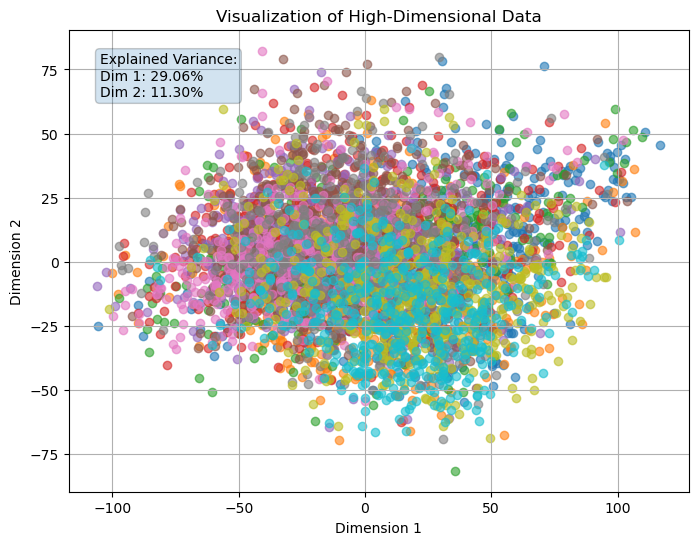

In [34]:
visualize_2d(train_features, train_labels)

# 训练FBM

In [41]:
import torch.optim as optim
import torch.nn.functional as F
from loss.loss import FBMLoss
from models.modelset import FBMLayer
from models.modelset import FBM_KANLayer

# 定义超参数
input_size = images_size
hidden_dim = 3000
num_classes = 10      # MNIST有10个类别
learning_rate = 0.01
num_epochs = 20
batch_size = 64
#alpha = 0.006548084
#df = 1.7666495380528981
df = 0.45
alpha=1.0

# 实例化模型、定义损失函数和优化器
#model = FBMLayer(input_size, hidden_dim).to(device)
model = FBM_KANLayer(input_size, hidden_dim).to(device)
#criterion = FBMLoss(hidden_dim, 0.01, df, alpha, losstype="fast_StrongInter")
criterion = FBMLoss(hidden_dim, 0.01, df, alpha, losstype="fast_FermiBose")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

model.train()
# 训练模型
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 将图像和标签移动到 GPU 上
        images = images.view(-1, input_size).to(device)  # 展平图像并转移到 GPU
        #images = images.to(device)  # 展平图像并转移到 GPU
        labels = labels.to(device)  # 标签移动到 GPU
        #labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
        
        # 前向传播
        outputs = model(images)
        #loss = criterion(outputs, labels_one_hot, model.linear.weight)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.4525
Epoch [2/20], Loss: 0.4504
Epoch [3/20], Loss: 0.2212
Epoch [4/20], Loss: 0.1556
Epoch [5/20], Loss: 0.1598
Epoch [6/20], Loss: 0.1797
Epoch [7/20], Loss: 0.1219
Epoch [8/20], Loss: 0.1544
Epoch [9/20], Loss: 0.1569
Epoch [10/20], Loss: 0.1705
Epoch [11/20], Loss: 0.1810
Epoch [12/20], Loss: 0.1281
Epoch [13/20], Loss: 0.1705
Epoch [14/20], Loss: 0.1817
Epoch [15/20], Loss: 0.1865
Epoch [16/20], Loss: 0.1443
Epoch [17/20], Loss: 0.1809
Epoch [18/20], Loss: 0.1671
Epoch [19/20], Loss: 0.1556
Epoch [20/20], Loss: 0.1737


# 观察分类完之后的数据分布

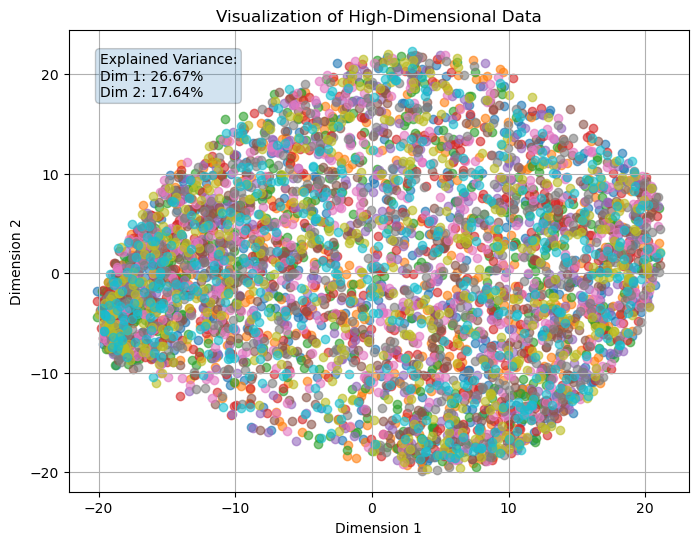

In [42]:
with torch.no_grad():
    out_features = model(origin_train_features.to(device)).cpu()
visualize_2d(out_features, train_labels)

# 计算处理之后的聚类结果

In [43]:
deal_test_loader = deal_dataloader(test_loader, model, device, batch_size = 64)
# 获取 DataLoader 中的全部数据
deal_test_features = []
deal_test_labels = []

for batch_data, batch_labels in deal_test_loader:
    deal_test_features.append(batch_data.view(-1, hidden_dim))
    deal_test_labels.append(batch_labels)

# 合并所有批次
deal_test_features = torch.cat(deal_test_features, dim=0)
deal_test_labels = torch.cat(deal_test_labels, dim=0)

data = deal_test_features.numpy()  # 展平
labels = deal_test_labels.numpy()
print(labels.shape)

# 2. 应用KMeans聚类
n_clusters = len(selected_classes)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(data)

# 3. 创建混淆矩阵
confusion_matrix = np.zeros((n_clusters, 10), dtype=np.int32)
for cluster in range(n_clusters):
    cluster_labels = labels[cluster_assignments == cluster]
    for label in range(10):
        confusion_matrix[cluster, label] = np.sum(cluster_labels == label)

print("混淆矩阵：")
print(confusion_matrix)

# 4. 使用匈牙利算法找到最佳标签分配
# 我们需要最大化正确分类，因此将混淆矩阵取负作为成本矩阵
cost_matrix = -confusion_matrix
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# 创建标签映射
cluster_to_label = {}
for cluster, label in zip(row_ind, col_ind):
    cluster_to_label[cluster] = label

print("\n聚类到标签的映射：")
for cluster in cluster_to_label:
    print(f"聚类 {cluster} -> 标签 {cluster_to_label[cluster]}")

# 5. 使用映射分配标签并计算准确率
predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_assignments])
accuracy = accuracy_score(labels, predicted_labels)
print(f"\n分类准确率: {accuracy * 100:.2f}%")

Processed data shape: torch.Size([5000, 3000])
(5000,)


/home/yixiong_ren/anaconda3/envs/normal/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


混淆矩阵：
[[ 36  62  19  34  29  21  13  98  69 170]
 [ 17  43 101  94 156  62 127  67   9  22]
 [ 89  38  20  38  11  76   1  30  73  21]
 [ 24  58  95  63 114  51 145  38  11  35]
 [ 21  44  20  45  11  31  44  59   7  74]
 [ 78  53  30  12  17  17   3  34 197  85]
 [ 24  18  93  37  64  54  57  34  11  18]
 [148  32  61  48  21  33  16  27  25  31]
 [ 11  34  22  76  54  73  32  62  17  17]
 [ 52 118  39  53  23  82  62  51  81  27]]

聚类到标签的映射：
聚类 0 -> 标签 9
聚类 1 -> 标签 4
聚类 2 -> 标签 5
聚类 3 -> 标签 6
聚类 4 -> 标签 7
聚类 5 -> 标签 8
聚类 6 -> 标签 2
聚类 7 -> 标签 0
聚类 8 -> 标签 3
聚类 9 -> 标签 1

分类准确率: 24.76%


In [44]:
from models.modelset import MLP
import torch.nn as nn

deal_train_loader = deal_dataloader(train_loader, model, device, batch_size = 64)

# 定义损失函数和优化器
model2 = MLP(hidden_dim, num_classes).to(device)
criterion2 = nn.CrossEntropyLoss()  # 使用交叉熵损失
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)  # 使用随机梯度下降优化器

model2.train()
# 训练模型
epochs = 50
for epoch in range(epochs):
    for images, labels in deal_train_loader:
        # 将图像展平为一维向量，并将标签进行 one-hot 编码
        images = images.to(device)
        labels_one_hot = F.one_hot(labels, num_classes=num_classes).float().to(device)  # 将标签转换为 one-hot 编码

        # 前向传播
        outputs = model2(images)

        # 计算损失
        loss = criterion2(outputs, labels_one_hot)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 设置模型为评估模式
model2.eval()

# 准确率计数
correct = 0
total = 0

# 禁用梯度计算，加速测试过程
with torch.no_grad():
    for images, labels in deal_test_loader:
        # 将数据加载到 GPU
        images = images.view(-1, hidden_dim).to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model2(images)
        
        # 获取预测结果
        _, predicted = torch.max(outputs, 1)
        
        # 更新计数
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = 1.0 * correct / total
print(accuracy)

Processed data shape: torch.Size([5000, 3000])
0.2954


In [4]:
a = 8
freeze_layers = [i for i in range(a//4, 3*a//4)]
freeze_layers

[2, 3, 4, 5]